In this code Data augmentation is done by flipping dataset images so that model is exposed to new sort of images.
Also a heatmap(CAM) is printed in the end for a sample input.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")
BATCH_SIZE = 25
DATA_DIR = ("/kaggle/input/lung-and-colon-cancer-histopathological-images/"
            "lung_colon_image_set/lung_image_sets")
IMG_SIZE = 256
MAX_EPOCHS = 25
class_names = ["lung_n", "lung_aca", "lung_scc"]
class_details = ["No Cancer", "Adenocarcinoma", "Squamous Cell Carcinoma"]

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomHeight(0.1),
    layers.experimental.preprocessing.RandomWidth(0.1),
])

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="training",
    validation_split=0.2
)

# Applying data augmentation to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                        num_parallel_calls=tf.data.AUTOTUNE)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation", 
    validation_split=0.2
)

# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Calculate class weights
class_weight = {}
total_samples = sum([len(files) for _, _, files in os.walk(DATA_DIR)])
for i, class_name in enumerate(class_names):
    class_weight[i] = (1 / (len(os.listdir(os.path.join(DATA_DIR, class_name))) / total_samples))

def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weight
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history


def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

2024-05-05 07:46:49.565235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 07:46:49.565289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 07:46:49.566797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


# Model with VGG16 base

In [2]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_vgg16_base.trainable = False

vgg16_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 14780739 (56.38 MB)
Trainable params: 66051 (258.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Epoch 1/25


I0000 00:00:1714895237.558587    1954 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


480/480 [==============================] - 98s 182ms/step - loss: 0.4007 - accuracy: 0.9522 - val_loss: 0.0917 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 2/25
480/480 [==============================] - 86s 179ms/step - loss: 0.1866 - accuracy: 0.9767 - val_loss: 0.1485 - val_accuracy: 0.9403 - lr: 0.0010
Epoch 3/25
480/480 [==============================] - 85s 178ms/step - loss: 0.1261 - accuracy: 0.9844 - val_loss: 0.0560 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 4/25
480/480 [==============================] - 85s 178ms/step - loss: 0.0749 - accuracy: 0.9915 - val_loss: 0.0436 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 5/25
480/480 [==============================] - 85s 178ms/step - loss: 0.0588 - accuracy: 0.9933 - val_loss: 0.0418 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 6/25
480/480 [==============================] - 85s 178ms/step - loss: 0.0519 - accuracy: 0.9938 - val_loss: 0.1025 - val_accuracy: 0.9657 - lr: 0.0010
Epoch 7/25
480/480 [==============================] - 85s 178ms

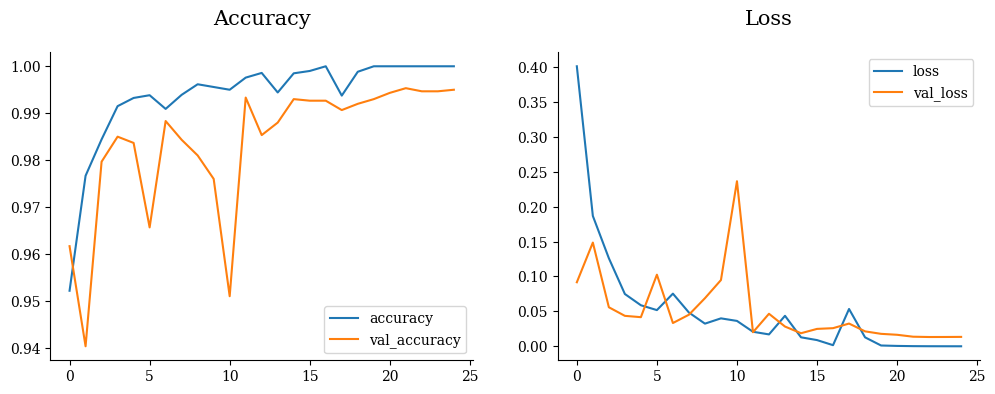

In [3]:
vgg16_history = compile_and_fit_model(vgg16_model)

1/1 [==============================] - 0s 226ms/step


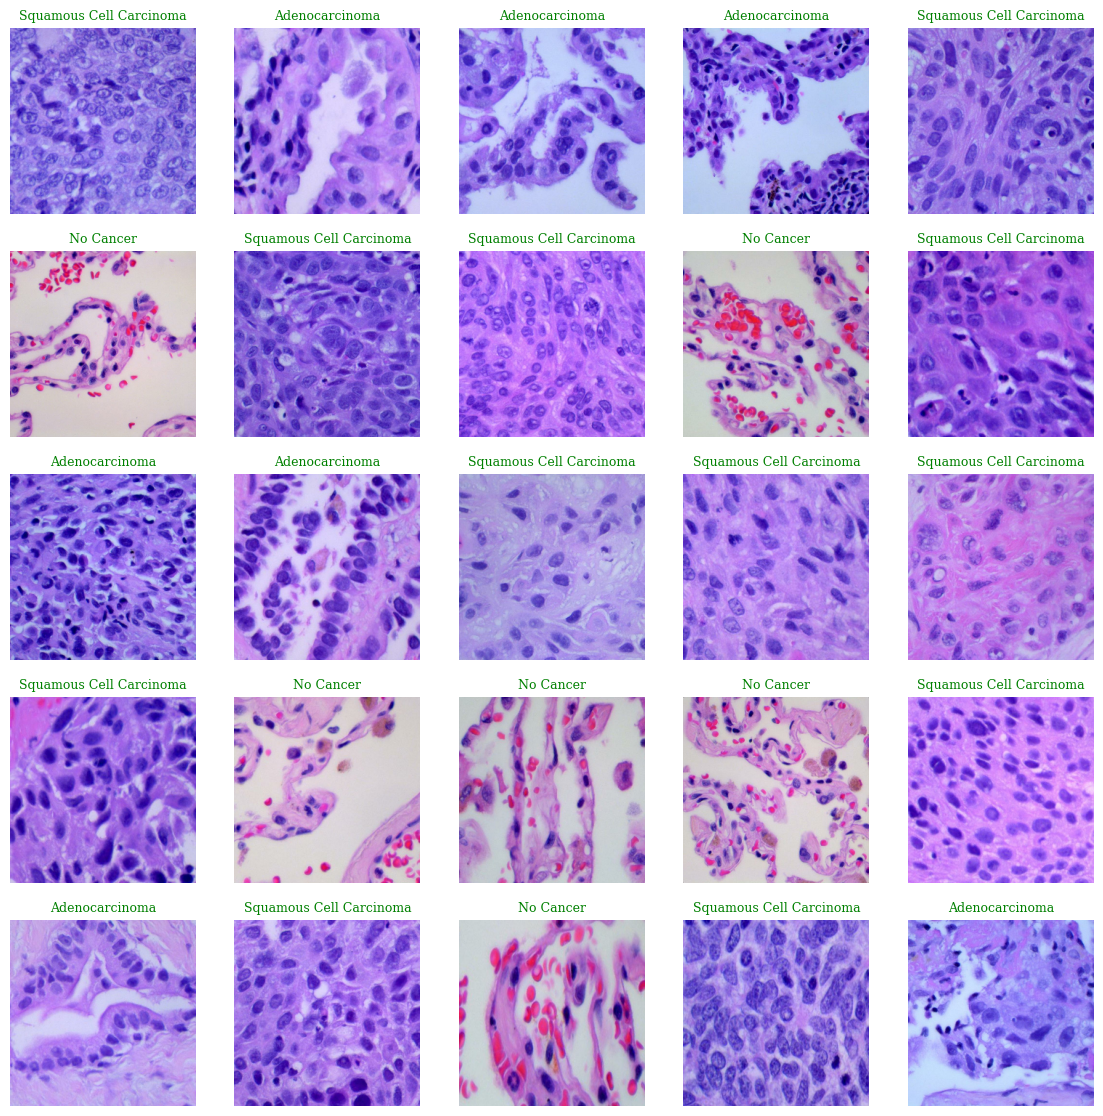

In [4]:
plot_predictions(vgg16_model)

# Model with ResNet50 base

In [5]:
pretrained_resnet_base = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_resnet_base.trainable = False

resnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input),
    pretrained_resnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 23827459 (90.89 MB)
Trainable params: 262659 (1.00 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


Epoch 1/25
480/480 [==============================] - 56s 109ms/step - loss: 0.0176 - accuracy: 0.9980 - val_loss: 0.0581 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 2/25
480/480 [==============================] - 51s 107ms/step - loss: 0.0337 - accuracy: 0.9961 - val_loss: 0.0888 - val_accuracy: 0.9753 - lr: 0.0010
Epoch 3/25
480/480 [==============================] - 51s 107ms/step - loss: 0.0188 - accuracy: 0.9983 - val_loss: 0.0703 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 4/25
480/480 [==============================] - 51s 106ms/step - loss: 0.0106 - accuracy: 0.9990 - val_loss: 0.0674 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 5/25
480/480 [==============================] - 51s 107ms/step - loss: 0.0124 - accuracy: 0.9985 - val_loss: 0.0430 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 6/25
480/480 [==============================] - 51s 107ms/step - loss: 0.0234 - accuracy: 0.9977 - val_loss: 0.0475 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 7/25
480/480 [==============================] 

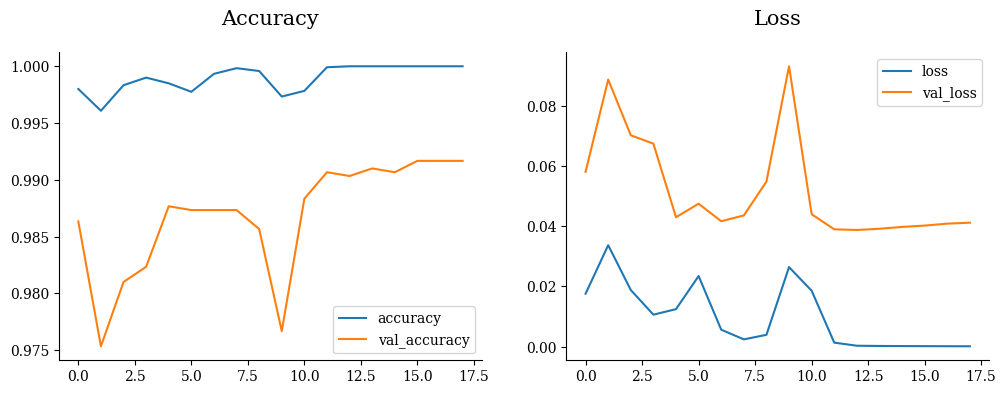

In [12]:
resnet_history = compile_and_fit_model(resnet_model)

1/1 [==============================] - 1s 884ms/step


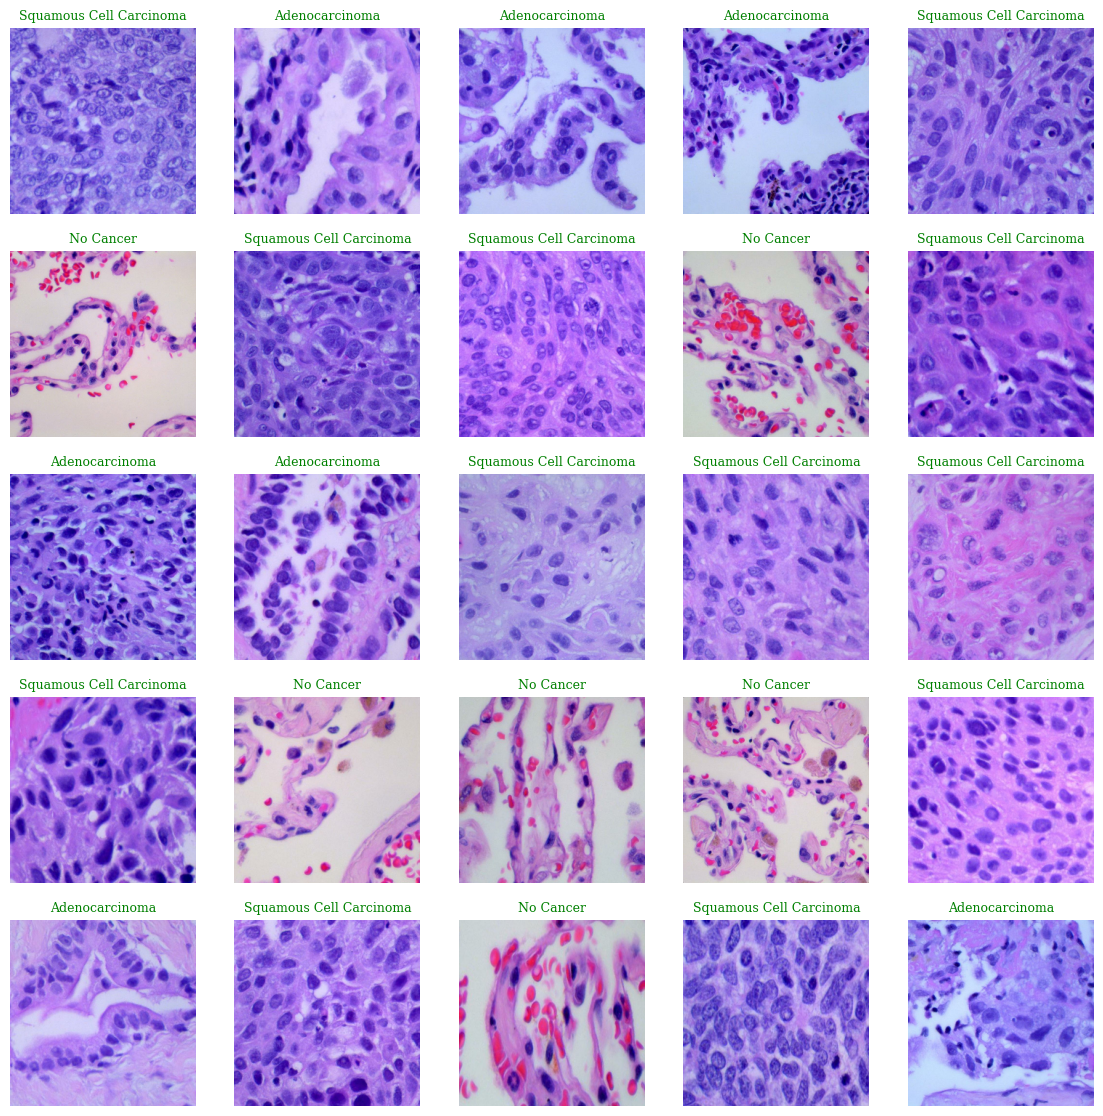

In [13]:
plot_predictions(resnet_model)

# Model with EfficientNetB1 base

In [15]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    pretrained_efficientnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 1280)              6575239   
 )                                                               
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6739594 (25.71 MB)
Trainable params: 164355 (642.01 KB)
Non-trainable params: 6575239 (25.08 MB)
_________________________________________________________________


Epoch 1/25


2024-05-05 09:21:57.379143: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


480/480 [==============================] - 62s 108ms/step - loss: 0.3185 - accuracy: 0.9584 - val_loss: 0.0461 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 2/25
480/480 [==============================] - 49s 103ms/step - loss: 0.1457 - accuracy: 0.9818 - val_loss: 0.0298 - val_accuracy: 0.9903 - lr: 0.0010
Epoch 3/25
480/480 [==============================] - 49s 103ms/step - loss: 0.1070 - accuracy: 0.9857 - val_loss: 0.0201 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 4/25
480/480 [==============================] - 49s 102ms/step - loss: 0.0850 - accuracy: 0.9896 - val_loss: 0.0244 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/25
480/480 [==============================] - 49s 103ms/step - loss: 0.0725 - accuracy: 0.9913 - val_loss: 0.0099 - val_accuracy: 0.9973 - lr: 0.0010
Epoch 6/25
480/480 [==============================] - 49s 102ms/step - loss: 0.0573 - accuracy: 0.9933 - val_loss: 0.0532 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 7/25
480/480 [==============================] - 49s 102ms

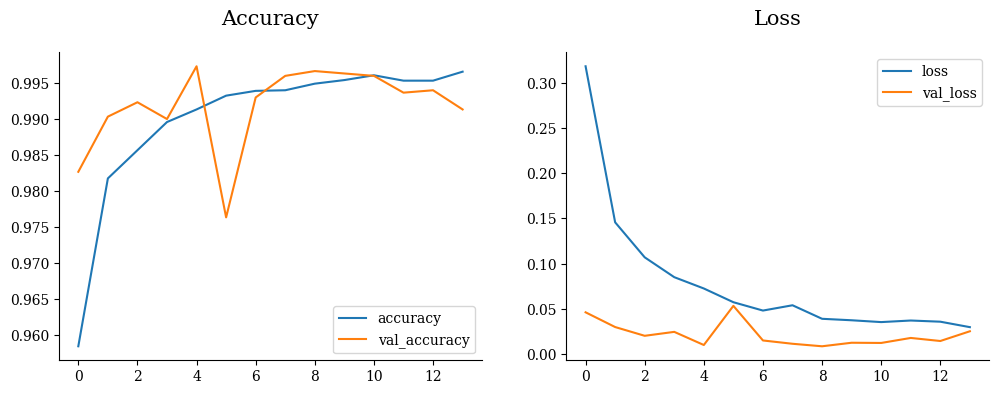

In [16]:
efficientnet_history = compile_and_fit_model(efficientnet_model)

1/1 [==============================] - 2s 2s/step


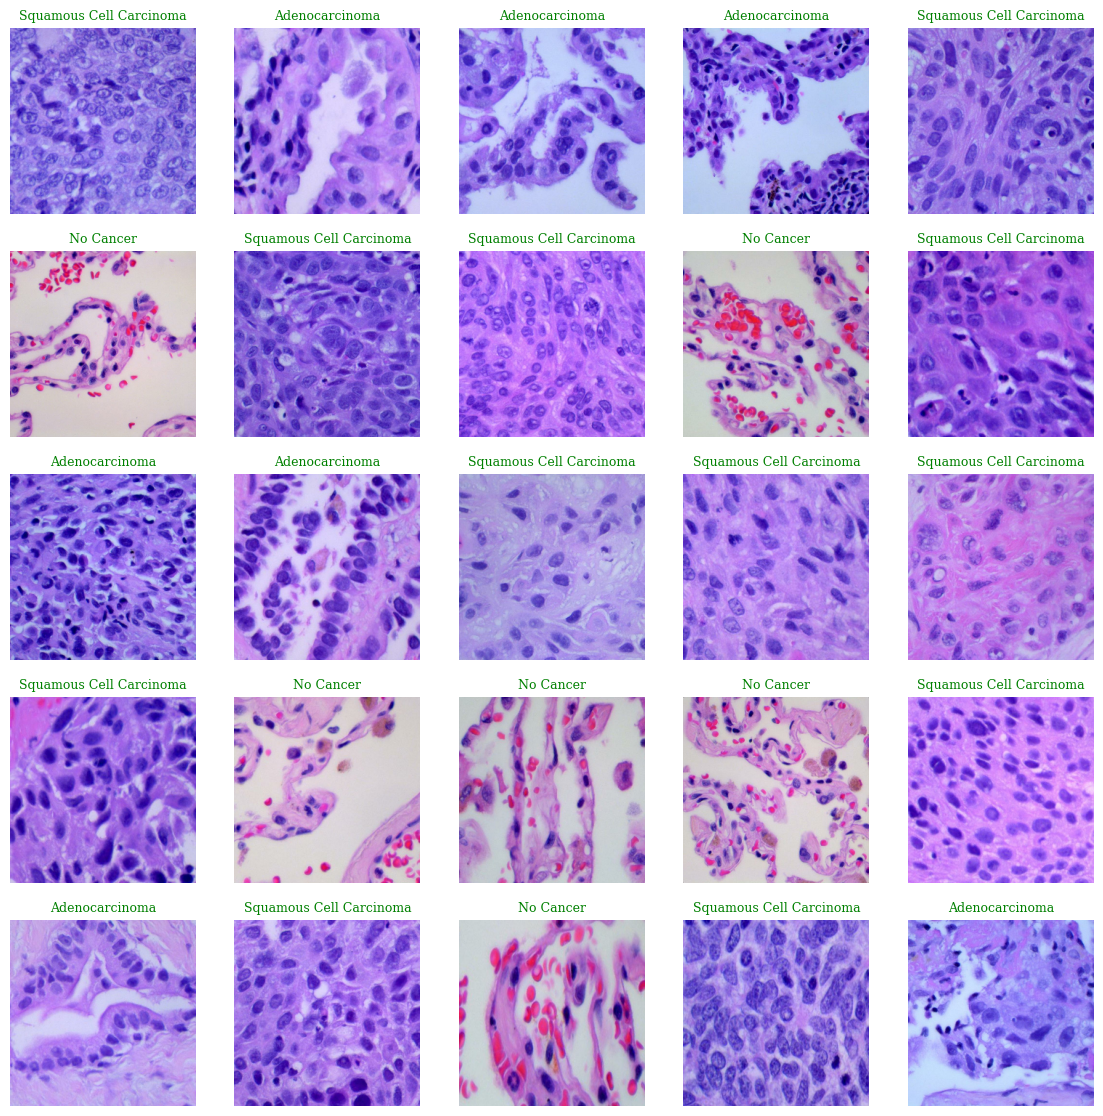

In [17]:
plot_predictions(efficientnet_model)

In [22]:
# Save the model
efficientnet_model.save("efficientnetb1_modelv2.h5")

In [30]:
# Take a batch from the dataset
batch = next(iter(train_ds.take(1)))

# Extract features during training
features = feature_extraction_model.predict(batch[0])

# Print the shape of extracted features
print("Shape of extracted features:", features.shape)

# Print the summary of the EfficientNetB1 base
pretrained_efficientnet_base.summary()


1/1 [==============================] - 2s 2s/step
Shape of extracted features: (25, 1280)
Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, None, None, 3)        0         ['input_8[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                              

# Comparison between 3 models

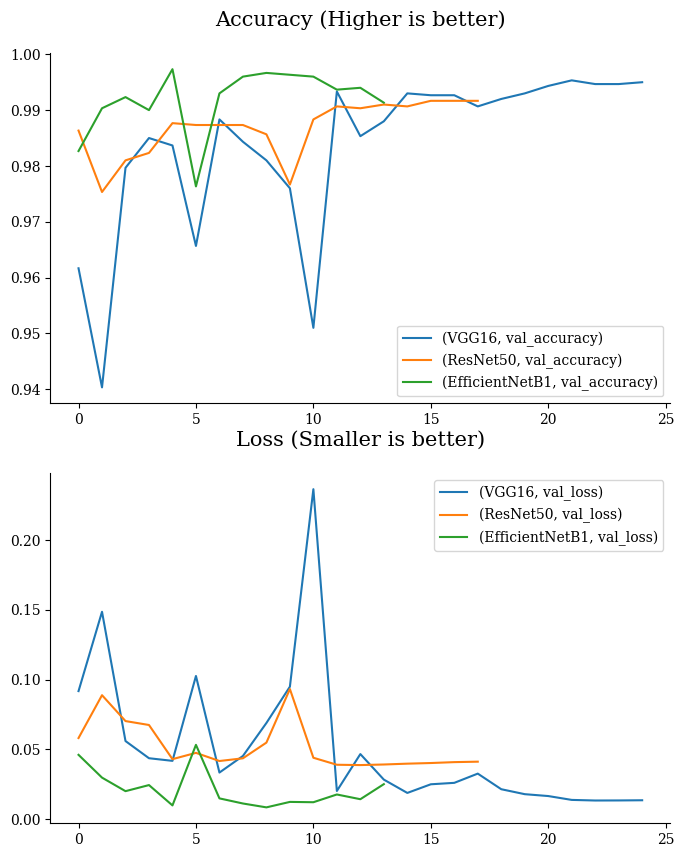

In [23]:
vgg_df = pd.DataFrame(vgg16_history.history)
resnet_df = pd.DataFrame(resnet_history.history)
efficientnet_df = pd.DataFrame(efficientnet_history.history)
combined = pd.concat([vgg_df, resnet_df, efficientnet_df], axis=1,
                     keys=["VGG16", "ResNet50", "EfficientNetB1"])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
combined.filter(like="val_accuracy").plot(ax=ax1)
combined.filter(like="val_loss").plot(ax=ax2)
ax1.set_title("Accuracy (Higher is better)", size=15, pad=20)
ax1.legend(title="")
ax2.set_title("Loss (Smaller is better)", size=15, pad=20)
_ = ax2.legend(title="")

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrices and classification report of three models

120/120 [==============================] - 17s 138ms/step


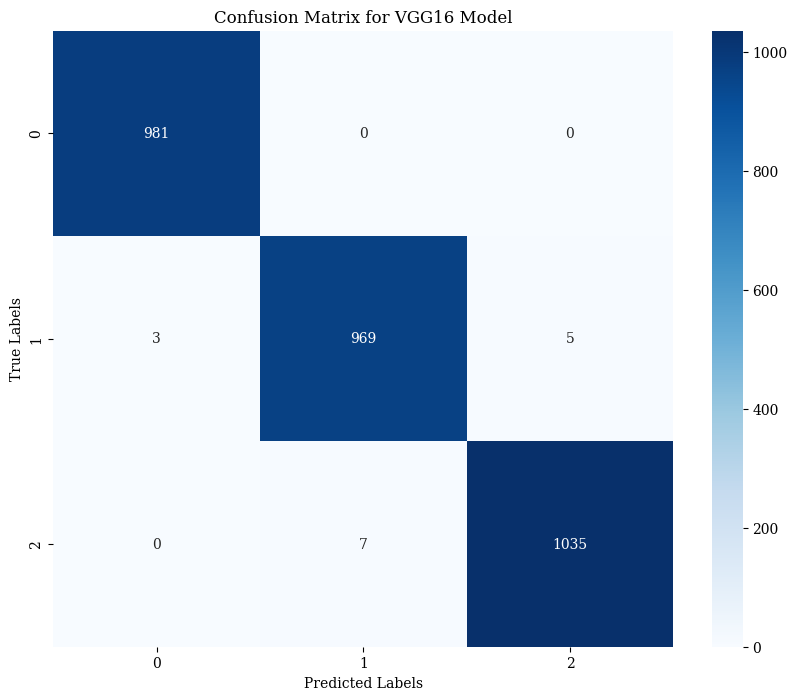

Classification Report for VGG16 Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       981
           1       0.99      0.99      0.99       977
           2       1.00      0.99      0.99      1042

    accuracy                           0.99      3000
   macro avg       0.99      1.00      1.00      3000
weighted avg       0.99      0.99      0.99      3000



In [25]:
from sklearn.metrics import classification_report

# Get the predicted labels for the validation dataset
vgg16_predicted_labels = np.argmax(vgg16_model.predict(validation_ds), axis=1)

# Get the true labels for the validation dataset
vgg16_true_labels = []
for _, labels in validation_ds:
    vgg16_true_labels.extend(labels.numpy())

# Generate the confusion matrix
vgg16_confusion_matrix = confusion_matrix(vgg16_true_labels, vgg16_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(vgg16_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for VGG16 Model')
plt.show()

# Generate the classification report
vgg16_classification_report = classification_report(vgg16_true_labels, vgg16_predicted_labels)

# Print the classification report
print("Classification Report for VGG16 Model:")
print(vgg16_classification_report)


120/120 [==============================] - 11s 81ms/step


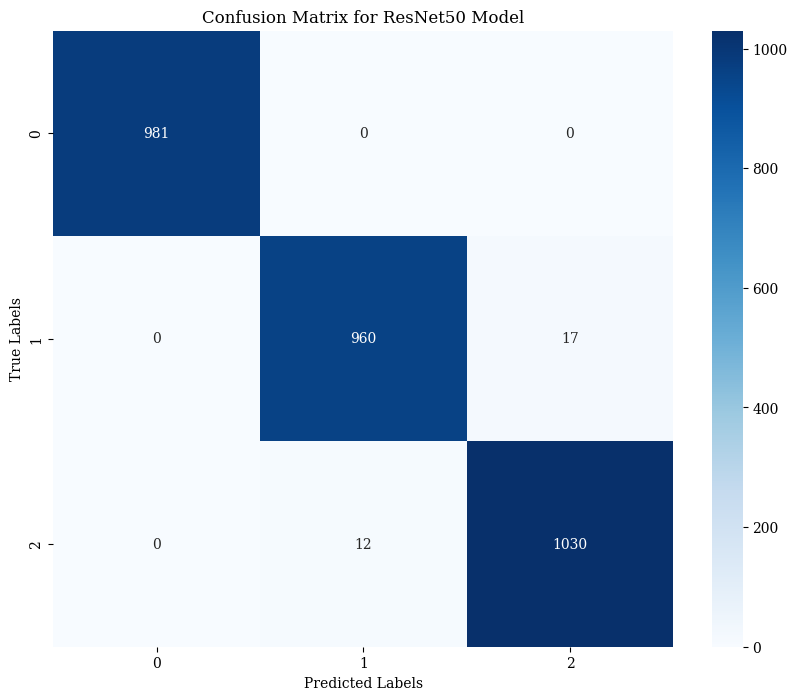

Classification Report for ResNet50 Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       981
           1       0.99      0.98      0.99       977
           2       0.98      0.99      0.99      1042

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [26]:
from sklearn.metrics import classification_report

# Get the predicted labels for the validation dataset
resnet_predicted_labels = np.argmax(resnet_model.predict(validation_ds), axis=1)

# Get the true labels for the validation dataset
resnet_true_labels = []
for _, labels in validation_ds:
    resnet_true_labels.extend(labels.numpy())

# Generate the confusion matrix
resnet_confusion_matrix = confusion_matrix(resnet_true_labels, resnet_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(resnet_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for ResNet50 Model')
plt.show()

# Generate and print the classification report
resnet_classification_report = classification_report(resnet_true_labels, resnet_predicted_labels)
print("Classification Report for ResNet50 Model:")
print(resnet_classification_report)

120/120 [==============================] - 12s 74ms/step


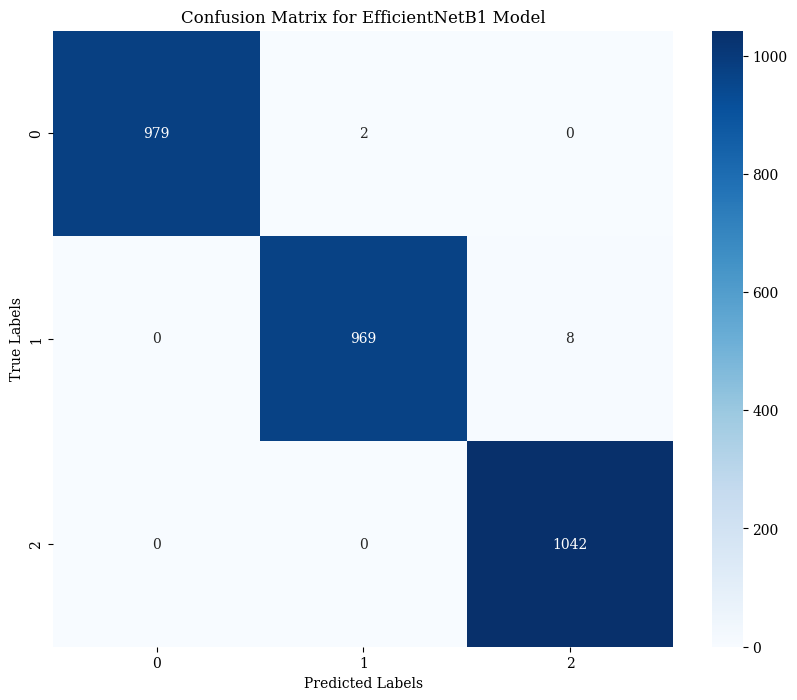

Classification Report for EfficientNetB1 Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       981
           1       1.00      0.99      0.99       977
           2       0.99      1.00      1.00      1042

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [27]:
from sklearn.metrics import classification_report

# Get the predicted labels for the validation dataset
efficientnet_predicted_labels = np.argmax(efficientnet_model.predict(validation_ds), axis=1)

# Get the true labels for the validation dataset
efficientnet_true_labels = []
for _, labels in validation_ds:
    efficientnet_true_labels.extend(labels.numpy())

# Generate the confusion matrix
efficientnet_confusion_matrix = confusion_matrix(efficientnet_true_labels, efficientnet_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(efficientnet_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for EfficientNetB1 Model')
plt.show()

# Generate and print the classification report
efficientnet_classification_report = classification_report(efficientnet_true_labels, efficientnet_predicted_labels)
print("Classification Report for EfficientNetB1 Model:")
print(efficientnet_classification_report)

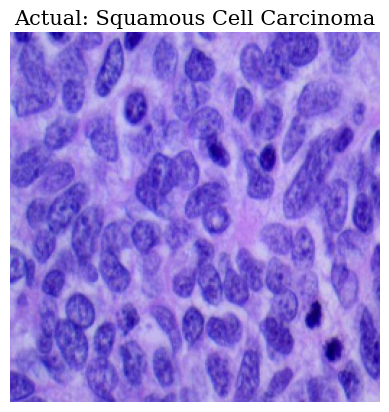

1/1 [==============================] - 0s 31ms/step


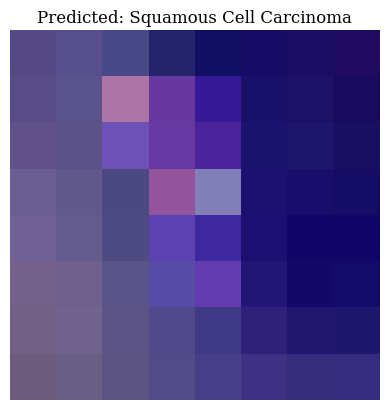

In [72]:
# Take a random image from the dataset
for images, labels in train_ds.take(1):
    sample_image = images[0]
    sample_label = labels[0].numpy()

# Define a function to visualize predictions and heatmap for a given model and image
def plot_predictions_with_heatmap(model, image):
    # Expand dimensions to match model input shape
    image = tf.expand_dims(image, axis=0)

    # Get predictions and determine predicted class index
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions[0])

    # Get the output of the last convolutional layer in the base model
    last_conv_layer = model.layers[0].get_layer("top_activation")
    last_conv_layer_model = tf.keras.Model(model.layers[0].input, last_conv_layer.output)

    # Compute gradients of the predicted class with regard to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs = last_conv_layer_model(image)
        loss = tf.reduce_mean(conv_outputs[:, :, :, predicted_class_index])

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is" with regard to the predicted class
    heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Plot heatmap on top of the original image
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.imshow(heatmap[0], cmap="magma", alpha=0.4)
    plt.title(f"Predicted: {class_details[predicted_class_index]}")
    plt.axis("off")
    plt.show()

# Take a random image from the dataset
for images, labels in train_ds.take(1):
    index = np.random.randint(0, BATCH_SIZE)
    sample_image = images[index]
    sample_label = labels[index].numpy()

# Visualize the sample image
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title(f"Actual: {class_details[sample_label]}", size=15)
plt.axis("off")
plt.show()

# Visualize predictions and heatmap for the sample image
plot_predictions_with_heatmap(efficientnet_model, sample_image)